# Generate data using Kramers model with hydrodynamic interactions

Without Brownian force, so in the limit $Wi \rightarrow +\infty$


In [7]:
import numpy as np
from dilutebrowniandynamics.simulate import simulate_batch
from dilutebrowniandynamics.molecules.Kramers_chain_EVHI import KramersChainEVHI
from dilutebrowniandynamics.molecules.Kramers_chain import KramersChain

from ipywidgets import interactive, fixed
import ipywidgets as widgets

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]

import json
import datetime
from copy import deepcopy

## Parameters definition

In [8]:
n_links = 1000                       # Number of segments in the Kramers chain
n_ensemble = 16                  # Number of molecules to simulate
n_proc = 16                         # Number of processor cores to use
seq = np.random.SeedSequence(2022)  # Random number seed
polydispersed = True

# Output folder
save_folder = 'outputs/Kramers'
                    
# Name output file
scenario = 'elongation_0_noBF_poly_HI'

## Initialise molecules
We call the `from_normal_distribution` constructor. Note that we pass a random seed (`SeedSequence` object) to ensure thread-safe random number generation and reproducible results.

1.0113603512418887
[ 999  970  984 1243 1031 1087 1033 1061 1041 1042  990  775 1133  844
  909 1118]


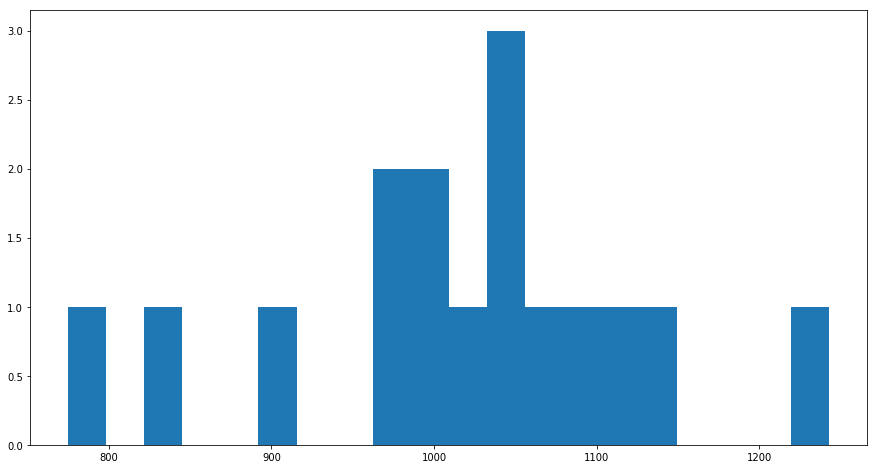

In [9]:

seeds = seq.spawn(n_ensemble)

if polydispersed:

    # Dispersity
    np.random.seed(2022)
    Ns = np.random.lognormal(mean=np.log(n_links), sigma=0.11, size=n_ensemble)  # 0.215
    Ns = Ns.astype(int)

    PDI = np.average(Ns**2)/np.average(Ns)**2
    print(PDI)
    print(Ns)

    plt.hist(Ns, 20)
    
    molecules = [KramersChainEVHI.from_normal_distribution(N, h_star=0., EVheight=0., EVsigma=0., seed=seed) for N, seed in zip(Ns, seeds)]

else:
    # Starting vectors
    molecules = [KramersChainEVHI.from_normal_distribution(n_links, h_star=0., EVheight=0., EVsigma=0., seed=seed)
                 for seed in seeds]

## Initial relaxation without HI
Molecular dynamics simulations are usually preceeded by a relaxation/thermalisation step, which in our case is just a simulation with no velocity gradient.

In [4]:
gradU = np.zeros((3, 3))
dt = .01                                    # Time step value (dimensionless)
n_steps = 1000       # Equilibriate at bead scale.
print(f"Number of time steps: {n_steps}")
write_interval = 100   # Record frequency (in number of time steps)
observables, molecules = simulate_batch(molecules, gradU, dt, n_steps, 
                                        write_interval=write_interval, 
                                        no_average=('g_max', 'i_max', 'g_13', 'g_12', 'g_23'),
                                        n_proc=n_proc)

Number of time steps: 1000
Physical time to compute: 10.0
Calculation started on 16 cores.


100%|██████████| 16/16 [00:02<00:00,  6.21it/s]


We can investigate the dumbbell distribution in a number of ways. Let's look at time series and histograms.

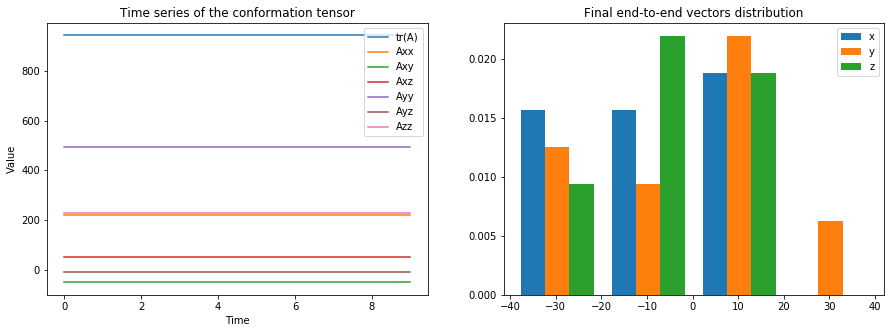

In [5]:
t = np.arange(n_steps//write_interval)*dt*write_interval
A = observables['A_average']
trA = np.trace(A, axis1=1, axis2=2)
REEs = np.array([molecule.REE for molecule in molecules])

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(t, trA, label='tr(A)')
ax[0].plot(t, A[:,0,0], label='Axx')
ax[0].plot(t, A[:,0,1], label='Axy')
ax[0].plot(t, A[:,0,2], label='Axz')
ax[0].plot(t, A[:,1,1], label='Ayy')
ax[0].plot(t, A[:,1,2], label='Ayz')
ax[0].plot(t, A[:,2,2], label='Azz')
ax[0].legend()
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Value')
ax[0].set_title('Time series of the conformation tensor')
bins = int(np.sqrt(n_ensemble))
ax[1].hist([REEs[:,0], REEs[:,1], REEs[:,2]], bins=bins, density=True, label=['x','y','z'])
ax[1].legend()
ax[1].set_title('Final end-to-end vectors distribution')
plt.show()

## Turn on HI

In [6]:
for molecule in molecules:
    molecule.h_star = 0.25

## Simulations

We simulate uniaxial elongation.

In [7]:
gradU = np.diag([1., -.5, -.5])
dt = 0.001
n_steps = 10000
write_interval = 10

# Simulate
# --------
print(f"Simulate {scenario}")
print(f"---------{'-'*len(scenario)}")
print(f"Number of time steps: {n_steps}")
print(f"Number of recorded steps: {n_steps//write_interval}")

pre = datetime.datetime.now()
    
observables, _ = simulate_batch(molecules, gradU, dt, n_steps, write_interval=write_interval,
                                no_average=('g_max', 'i_max', 'g_13', 'g_12', 'g_23'),
                                n_proc=n_proc)
    
observables['t'] = np.arange(n_steps//write_interval)*dt*write_interval
observables['gradU'] = gradU
     
# Save
# ----
params = {'model': molecules[0].__class__.__name__,
          'n_links': n_links,
          'n_ensemble': n_ensemble,
          'dt': dt,
          'write_interval': write_interval,
          'n_proc': n_proc,
          'compute date': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
          'compute cost': str(datetime.datetime.now() - pre)
          }

np.savez_compressed(f"{save_folder}/{scenario}_nlinks{n_links}_nmol{n_ensemble}", **observables)
json.dump(params, open( f"{save_folder}/{scenario}_nlinks{n_links}_nmol{n_ensemble}.json", 'w' ) )

Simulate elongation_0_noBF_poly_HI
----------------------------------
Number of time steps: 10000
Number of recorded steps: 1000
Physical time to compute: 10.0
Calculation started on 16 cores.


100%|██████████| 16/16 [61:23:18<00:00, 13812.38s/it]    


## Inspect

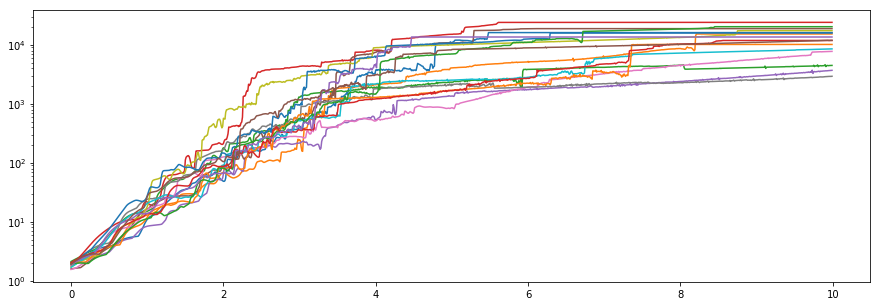

In [8]:
for i in range(n_ensemble):
    plt.semilogy(observables['t'], observables['g_max'][i], '-')

In [9]:
61/24

2.5416666666666665